In [ ]:
from collections import deque

import gym
from gym import wrappers, logger

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

In [68]:
SAV = "img/"

In [79]:
def plot_reward(rewards, title="", file_name="error", mean_size=100):
    list_e = []
    x_s = []
    i = 0
    if mean_size < 2:
        list_e = rewards
        x_s = range(len(rewards))
    else:
        while i < len(rewards):
            max_mean = i + mean_size
            if max_mean >= len(rewards):
                max_mean = len(rewards) - 1
            list_e.append(sum(rewards[i:max_mean])/(max_mean - i))
            x_s.append((max_mean + i)/2)
            i += mean_size
    # for error in errors:
    #     list_e.append(error.item())
    plt.figure(figsize=(10, 10))
    # plt.plot(x_s, list_e, 'ok')
    # plt.bar(x_s, list_e)
    plt.plot(list_e, 'k')
    plt.ylabel("Récompense")
    plt.xlabel("Itération")
    plt.title(title)
    if file_name:
        plt.savefig(f"{SAV}{env_name}/{file_name}.png")
    plt.show()


In [ ]:
class Experience:
    def __init__(self, _state, _action, _reward, _next_state, _done):
        self.state = _state
        self.action = _action
        self.reward = _reward
        self.next_state = _next_state
        self.done = _done

In [ ]:
env_name = 'CartPole-v1'

In [ ]:
# def blotzmann(qvalues, tau=0.01):
#     prob = []
#     for qvalue in qvalues:
#         prob.append()
#     print("lol")

def epsilongreedy(qvalues, epsilon=0.5):
    _, max_ind = qvalues.max(0)
    # print(max_ind)
    return np.random.randint(len(qvalues)) if np.random.random() < epsilon else max_ind.item()

In [ ]:
class Net(nn.Module):
    def __init__(self, in_size, out_size):
        super(Net, self).__init__()
        print(in_size, out_size)
        self.in_l = nn.Linear(in_size, 3)
        self.in_l2 = nn.Linear(3, out_size)

    def forward(self, x):
        x = F.sigmoid(self.in_l(x))
        x = F.sigmoid(self.in_l2(x))
        return x

In [ ]:
class Agent:
    def __init__(self, _net):
        self.mem = deque(maxlen=10000)
        self.net = _net
        self.gamma = 0.95

    def choose_action(self, _observation, _reward, _done):
        qvalues = self.qvalue(_observation)
        # print(qvalues)
        action_ind = epsilongreedy(qvalues, epsilon=0.05)
        # print(action_ind)
        return action_ind
        # return self.action_space.sample()

    def experience(self, _state, _action, _reward, _next_state, _done):
        self.mem.append(Experience(_state, _action, _reward, _next_state, _done))

    def minibatch(self, size=5):
        batch_s = min(size, len(self.mem))
        return random.sample(self.mem, batch_s)

    def qvalue(self, state):
        inp = torch.tensor(state).type(torch.FloatTensor)
        # for w in self.W[:-1]:
        #     # inp = torch.cat((torch.Tensor([1.0]), inp))
        #     # inp = func(torch.mv(w, inp))
        #     inp = 1/(1 + torch.exp(-torch.mv(w, inp)))
        # return torch.mv(self.W[-1], inp.float())
        out = self.net(inp)
        # print(f"inp {inp}")
        # print(f"out {out}")
        return out

In [ ]:
# You can set the level to logger.DEBUG or logger.WARN if you
# want to change the amount of output.
logger.set_level(logger.INFO)

env = gym.make(env_name)

# You provide the directory to write to (can be an existing
# directory, including one with existing data -- all monitor files
# will be namespaced). You can also dump to a tempdir if you'd
# like: tempfile.mkdtemp().
outdir = '/tmp/random-agent-results'
env = wrappers.Monitor(env, directory=outdir, force=True, video_callable=False)
env.seed(0)
observation_size = env.observation_space.shape[0]
action_size = env.action_space.n

net = Net(observation_size, env.action_space.n)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
agent = Agent(net)

episode_count = 5000
reward = 0
batch_size = 32
done = False

rewards = []

In [62]:
for i in range(episode_count):
    ob = env.reset()
    rewardSum = 0
    steps = 0
    done = False
    while not done:
        with torch.no_grad():
            action = agent.choose_action(ob, reward, done)
        current_state = ob
        ob, reward, done, _ = env.step(action)
        rewardSum += reward
        steps += 1

        # Experience replay
        agent.experience(current_state, action, reward, ob, done)
        minibatch = agent.minibatch(size=batch_size)
        for batch in minibatch:
            optimizer.zero_grad()
            with torch.no_grad():
                yj = batch.reward
                if not batch.done:
                    yj += agent.gamma * agent.qvalue(batch.next_state).max().item()
            qvalues = agent.qvalue(batch.state)
            real_y = qvalues.clone()
            # print(f"size : {qvalues.size()}")
            # print(f"real : {real_y}")
            # real_y = torch.zeros(qvalues.size())
            new_q = (qvalues[batch.action].item() - yj) ** 2
            real_y[batch.action] = new_q
            # print(f"old {real_y[batch.action].item()}")
            # print(f"new {new_q}")
            # print(f"new ? {real_y[batch.action].item()}")
            # print(f"qvalues {qvalues}")
            # print(f"real_y {real_y}")
            loss = criterion(qvalues, real_y)
            loss.backward()
            optimizer.step()
        if done:
            print(f"ep {i} : reward {rewardSum}")
            rewards.append(rewardSum)



env.close()

ep 2750 : reward 41.0


ep 2751 : reward 24.0


ep 2752 : reward 67.0


ep 2753 : reward 47.0


ep 2754 : reward 25.0


ep 2755 : reward 41.0


ep 2756 : reward 31.0


ep 2757 : reward 30.0


ep 2758 : reward 42.0


ep 2759 : reward 25.0


ep 2760 : reward 30.0


ep 2761 : reward 68.0


ep 2762 : reward 58.0


ep 2763 : reward 23.0


ep 2764 : reward 33.0


ep 2765 : reward 60.0


ep 2766 : reward 37.0


ep 2767 : reward 23.0


ep 2768 : reward 49.0


ep 2769 : reward 33.0


ep 2770 : reward 46.0


ep 2771 : reward 33.0


ep 2772 : reward 80.0


ep 2773 : reward 27.0


ep 2774 : reward 20.0


ep 2775 : reward 76.0


ep 2776 : reward 25.0


ep 2777 : reward 75.0


ep 2778 : reward 23.0


ep 2779 : reward 29.0


ep 2780 : reward 23.0


ep 2781 : reward 32.0


ep 2782 : reward 40.0


ep 2783 : reward 40.0


ep 2784 : reward 39.0


ep 2785 : reward 21.0


ep 2786 : reward 37.0


ep 2787 : reward 90.0


ep 2788 : reward 38.0


ep 2789 : reward 27.0


ep 2790 : reward 33.0


ep 2791 : reward 28.0


ep 2792 : reward 34.0


ep 2793 : reward 33.0


ep 2794 : reward 70.0


ep 2795 : reward 37.0


ep 2796 : reward 38.0


ep 2797 : reward 21.0


ep 2798 : reward 77.0


ep 2799 : reward 30.0


ep 2800 : reward 57.0


ep 2801 : reward 24.0


ep 2802 : reward 43.0


ep 2803 : reward 50.0


ep 2804 : reward 98.0


ep 2805 : reward 38.0


ep 2806 : reward 48.0


ep 2807 : reward 48.0


ep 2808 : reward 27.0


ep 2809 : reward 27.0


ep 2810 : reward 69.0


ep 2811 : reward 32.0


ep 2812 : reward 55.0


ep 2813 : reward 24.0


ep 2814 : reward 29.0


ep 2815 : reward 36.0


ep 2816 : reward 25.0


ep 2817 : reward 41.0


ep 2818 : reward 43.0


ep 2819 : reward 35.0


ep 2820 : reward 61.0


ep 2821 : reward 29.0


ep 2822 : reward 22.0


ep 2823 : reward 27.0


ep 2824 : reward 19.0


ep 2825 : reward 25.0


ep 2826 : reward 71.0


ep 2827 : reward 21.0


ep 2828 : reward 35.0


ep 2829 : reward 39.0


ep 2830 : reward 28.0


ep 2831 : reward 43.0


ep 2832 : reward 32.0


ep 2833 : reward 19.0


ep 2834 : reward 35.0


ep 2835 : reward 53.0


ep 2836 : reward 23.0


ep 2837 : reward 38.0


ep 2838 : reward 21.0


ep 2839 : reward 30.0


ep 2840 : reward 23.0


ep 2841 : reward 31.0


ep 2842 : reward 36.0


ep 2843 : reward 28.0


ep 2844 : reward 19.0


ep 2845 : reward 18.0


ep 2846 : reward 24.0


ep 2847 : reward 24.0


ep 2848 : reward 24.0


ep 2849 : reward 20.0


ep 2850 : reward 40.0


ep 2851 : reward 27.0


ep 2852 : reward 30.0


ep 2853 : reward 31.0


ep 2854 : reward 32.0


ep 2855 : reward 41.0


ep 2856 : reward 25.0


ep 2857 : reward 29.0


ep 2858 : reward 21.0


ep 2859 : reward 27.0


ep 2860 : reward 19.0


ep 2861 : reward 23.0


ep 2862 : reward 21.0


ep 2863 : reward 24.0


ep 2864 : reward 25.0


ep 2865 : reward 20.0


ep 2866 : reward 55.0


ep 2867 : reward 35.0


ep 2868 : reward 27.0


ep 2869 : reward 24.0


ep 2870 : reward 29.0


ep 2871 : reward 33.0


ep 2872 : reward 24.0


ep 2873 : reward 21.0


ep 2874 : reward 25.0


ep 2875 : reward 20.0


ep 2876 : reward 28.0


ep 2877 : reward 20.0


ep 2878 : reward 35.0


ep 2879 : reward 18.0


ep 2880 : reward 24.0


ep 2881 : reward 28.0


ep 2882 : reward 18.0


ep 2883 : reward 19.0


ep 2884 : reward 26.0


ep 2885 : reward 17.0


ep 2886 : reward 21.0


ep 2887 : reward 27.0


ep 2888 : reward 23.0


ep 2889 : reward 28.0


ep 2890 : reward 22.0


ep 2891 : reward 24.0


ep 2892 : reward 24.0


ep 2893 : reward 36.0


ep 2894 : reward 23.0


ep 2895 : reward 24.0


ep 2896 : reward 18.0


ep 2897 : reward 25.0


ep 2898 : reward 47.0


ep 2899 : reward 18.0


ep 2900 : reward 38.0


ep 2901 : reward 36.0


ep 2902 : reward 42.0


ep 2903 : reward 31.0


ep 2904 : reward 47.0


ep 2905 : reward 58.0


ep 2906 : reward 23.0


ep 2907 : reward 30.0


ep 2908 : reward 19.0


ep 2909 : reward 22.0


ep 2910 : reward 22.0


ep 2911 : reward 23.0


ep 2912 : reward 26.0


ep 2913 : reward 29.0


ep 2914 : reward 25.0


ep 2915 : reward 57.0


ep 2916 : reward 23.0


ep 2917 : reward 19.0


ep 2918 : reward 30.0


ep 2919 : reward 27.0


ep 2920 : reward 19.0


ep 2921 : reward 15.0


ep 2922 : reward 27.0


ep 2923 : reward 25.0


ep 2924 : reward 21.0


ep 2925 : reward 21.0


ep 2926 : reward 34.0


ep 2927 : reward 33.0


ep 2928 : reward 24.0


ep 2929 : reward 23.0


ep 2930 : reward 29.0


ep 2931 : reward 17.0


ep 2932 : reward 43.0


ep 2933 : reward 20.0


ep 2934 : reward 27.0


ep 2935 : reward 22.0


ep 2936 : reward 38.0


ep 2937 : reward 20.0


ep 2938 : reward 25.0


ep 2939 : reward 20.0


ep 2940 : reward 19.0


ep 2941 : reward 26.0


ep 2942 : reward 24.0


ep 2943 : reward 24.0


ep 2944 : reward 33.0


ep 2945 : reward 25.0


ep 2946 : reward 38.0


ep 2947 : reward 34.0


ep 2948 : reward 34.0


ep 2949 : reward 25.0


ep 2950 : reward 34.0


ep 2951 : reward 25.0


ep 2952 : reward 29.0


ep 2953 : reward 23.0


ep 2954 : reward 26.0


ep 2955 : reward 30.0


ep 2956 : reward 20.0


ep 2957 : reward 34.0


ep 2958 : reward 44.0


ep 2959 : reward 40.0


ep 2960 : reward 38.0


ep 2961 : reward 31.0


ep 2962 : reward 24.0


ep 2963 : reward 40.0


ep 2964 : reward 25.0


ep 2965 : reward 33.0


ep 2966 : reward 26.0


ep 2967 : reward 20.0


ep 2968 : reward 30.0


ep 2969 : reward 26.0


ep 2970 : reward 25.0


ep 2971 : reward 27.0


ep 2972 : reward 21.0


ep 2973 : reward 23.0


ep 2974 : reward 34.0


ep 2975 : reward 32.0


ep 2976 : reward 31.0


ep 2977 : reward 47.0


ep 2978 : reward 34.0


ep 2979 : reward 22.0


ep 2980 : reward 31.0


ep 2981 : reward 29.0


ep 2982 : reward 37.0


ep 2983 : reward 30.0


ep 2984 : reward 25.0


ep 2985 : reward 32.0


ep 2986 : reward 27.0


ep 2987 : reward 33.0


ep 2988 : reward 43.0


ep 2989 : reward 41.0


ep 2990 : reward 23.0


ep 2991 : reward 40.0


ep 2992 : reward 52.0


ep 2993 : reward 24.0


ep 2994 : reward 34.0


ep 2995 : reward 31.0


ep 2996 : reward 37.0


ep 2997 : reward 43.0


ep 2998 : reward 55.0


ep 2999 : reward 33.0


ep 3000 : reward 43.0


ep 3001 : reward 38.0


ep 3002 : reward 49.0


ep 3003 : reward 37.0


ep 3004 : reward 33.0


ep 3005 : reward 36.0


ep 3006 : reward 36.0


ep 3007 : reward 27.0


ep 3008 : reward 43.0


ep 3009 : reward 28.0


ep 3010 : reward 30.0


ep 3011 : reward 39.0


ep 3012 : reward 41.0


ep 3013 : reward 64.0


ep 3014 : reward 25.0


ep 3015 : reward 52.0


ep 3016 : reward 28.0


ep 3017 : reward 48.0


ep 3018 : reward 33.0


ep 3019 : reward 45.0


ep 3020 : reward 30.0


ep 3021 : reward 37.0


ep 3022 : reward 24.0


ep 3023 : reward 34.0


ep 3024 : reward 78.0


ep 3025 : reward 78.0


ep 3026 : reward 30.0


ep 3027 : reward 45.0


ep 3028 : reward 35.0


ep 3029 : reward 29.0


ep 3030 : reward 23.0


ep 3031 : reward 29.0


ep 3032 : reward 45.0


ep 3033 : reward 39.0


ep 3034 : reward 35.0


ep 3035 : reward 36.0


ep 3036 : reward 33.0


ep 3037 : reward 34.0


ep 3038 : reward 35.0


ep 3039 : reward 23.0


ep 3040 : reward 34.0


ep 3041 : reward 31.0


ep 3042 : reward 50.0


ep 3043 : reward 43.0


ep 3044 : reward 33.0


ep 3045 : reward 54.0


ep 3046 : reward 27.0


ep 3047 : reward 35.0


ep 3048 : reward 32.0


ep 3049 : reward 150.0


ep 3050 : reward 52.0


ep 3051 : reward 53.0


ep 3052 : reward 25.0


ep 3053 : reward 37.0


ep 3054 : reward 29.0


ep 3055 : reward 27.0


ep 3056 : reward 34.0


ep 3057 : reward 41.0


ep 3058 : reward 34.0


ep 3059 : reward 31.0


ep 3060 : reward 30.0


ep 3061 : reward 32.0


ep 3062 : reward 74.0


ep 3063 : reward 29.0


ep 3064 : reward 32.0


ep 3065 : reward 78.0


ep 3066 : reward 59.0


ep 3067 : reward 36.0


ep 3068 : reward 40.0


ep 3069 : reward 22.0


ep 3070 : reward 34.0


ep 3071 : reward 41.0


ep 3072 : reward 24.0


ep 3073 : reward 32.0


ep 3074 : reward 37.0


ep 3075 : reward 41.0


ep 3076 : reward 23.0


ep 3077 : reward 31.0


ep 3078 : reward 26.0


ep 3079 : reward 32.0


ep 3080 : reward 36.0


ep 3081 : reward 54.0


ep 3082 : reward 36.0


ep 3083 : reward 31.0


ep 3084 : reward 33.0


ep 3085 : reward 36.0


ep 3086 : reward 28.0


ep 3087 : reward 26.0


ep 3088 : reward 34.0


ep 3089 : reward 26.0


ep 3090 : reward 42.0


ep 3091 : reward 26.0


ep 3092 : reward 41.0


ep 3093 : reward 26.0


ep 3094 : reward 28.0


ep 3095 : reward 68.0


ep 3096 : reward 32.0


ep 3097 : reward 44.0


ep 3098 : reward 35.0


ep 3099 : reward 32.0


ep 3100 : reward 38.0


ep 3101 : reward 56.0


ep 3102 : reward 44.0


ep 3103 : reward 42.0


ep 3104 : reward 48.0


ep 3105 : reward 33.0


ep 3106 : reward 34.0


ep 3107 : reward 44.0


ep 3108 : reward 30.0


ep 3109 : reward 58.0


ep 3110 : reward 54.0


ep 3111 : reward 34.0


ep 3112 : reward 30.0


ep 3113 : reward 50.0


ep 3114 : reward 34.0


ep 3115 : reward 58.0


ep 3116 : reward 71.0


ep 3117 : reward 36.0


ep 3118 : reward 72.0


ep 3119 : reward 44.0


ep 3120 : reward 38.0


ep 3121 : reward 56.0


ep 3122 : reward 56.0


ep 3123 : reward 116.0


ep 3124 : reward 37.0


ep 3125 : reward 44.0


ep 3126 : reward 32.0


ep 3127 : reward 50.0


ep 3128 : reward 63.0


ep 3129 : reward 109.0


ep 3130 : reward 43.0


ep 3131 : reward 53.0


ep 3132 : reward 38.0


ep 3133 : reward 41.0


ep 3134 : reward 60.0


ep 3135 : reward 57.0


ep 3136 : reward 83.0


ep 3137 : reward 61.0


ep 3138 : reward 52.0


ep 3139 : reward 69.0


ep 3140 : reward 60.0


ep 3141 : reward 41.0


ep 3142 : reward 37.0


ep 3143 : reward 54.0


ep 3144 : reward 41.0


ep 3145 : reward 39.0


ep 3146 : reward 80.0


ep 3147 : reward 50.0


ep 3148 : reward 42.0


ep 3149 : reward 123.0


ep 3150 : reward 40.0


ep 3151 : reward 31.0


ep 3152 : reward 70.0


ep 3153 : reward 22.0


ep 3154 : reward 35.0


ep 3155 : reward 28.0


ep 3156 : reward 92.0


ep 3157 : reward 27.0


ep 3158 : reward 80.0


ep 3159 : reward 84.0


ep 3160 : reward 33.0


ep 3161 : reward 27.0


ep 3162 : reward 29.0


ep 3163 : reward 53.0


ep 3164 : reward 44.0


ep 3165 : reward 23.0


ep 3166 : reward 34.0


ep 3167 : reward 53.0


ep 3168 : reward 62.0


ep 3169 : reward 31.0


ep 3170 : reward 23.0


ep 3171 : reward 31.0


ep 3172 : reward 43.0


ep 3173 : reward 32.0


ep 3174 : reward 26.0


ep 3175 : reward 42.0


ep 3176 : reward 36.0


ep 3177 : reward 28.0


ep 3178 : reward 30.0


ep 3179 : reward 72.0


ep 3180 : reward 60.0


ep 3181 : reward 90.0


ep 3182 : reward 71.0


ep 3183 : reward 68.0


ep 3184 : reward 85.0


ep 3185 : reward 70.0


ep 3186 : reward 78.0


ep 3187 : reward 153.0


ep 3188 : reward 55.0


ep 3189 : reward 34.0


ep 3190 : reward 40.0


ep 3191 : reward 49.0


ep 3192 : reward 70.0


ep 3193 : reward 40.0


ep 3194 : reward 40.0


ep 3195 : reward 48.0


ep 3196 : reward 84.0


ep 3197 : reward 50.0


ep 3198 : reward 50.0


ep 3199 : reward 43.0


ep 3200 : reward 43.0


ep 3201 : reward 45.0


ep 3202 : reward 79.0


ep 3203 : reward 38.0


ep 3204 : reward 46.0


ep 3205 : reward 60.0


ep 3206 : reward 58.0


ep 3207 : reward 52.0


ep 3208 : reward 49.0


ep 3209 : reward 32.0


ep 3210 : reward 45.0


ep 3211 : reward 69.0


ep 3212 : reward 42.0


ep 3213 : reward 145.0


ep 3214 : reward 43.0


ep 3215 : reward 38.0


ep 3216 : reward 53.0


ep 3217 : reward 44.0


ep 3218 : reward 38.0


ep 3219 : reward 71.0


ep 3220 : reward 56.0


ep 3221 : reward 48.0


ep 3222 : reward 119.0


ep 3223 : reward 53.0


ep 3224 : reward 56.0


ep 3225 : reward 67.0


ep 3226 : reward 51.0


ep 3227 : reward 43.0


ep 3228 : reward 52.0


ep 3229 : reward 34.0


ep 3230 : reward 32.0


ep 3231 : reward 53.0


ep 3232 : reward 118.0


ep 3233 : reward 167.0


ep 3234 : reward 54.0


ep 3235 : reward 41.0


ep 3236 : reward 67.0


ep 3237 : reward 103.0


ep 3238 : reward 56.0


ep 3239 : reward 72.0


ep 3240 : reward 64.0


ep 3241 : reward 82.0


ep 3242 : reward 54.0


ep 3243 : reward 78.0


ep 3244 : reward 108.0


ep 3245 : reward 128.0


ep 3246 : reward 121.0


ep 3247 : reward 52.0


ep 3248 : reward 87.0


ep 3249 : reward 99.0


ep 3250 : reward 84.0


ep 3251 : reward 39.0


ep 3252 : reward 34.0


ep 3253 : reward 31.0


ep 3254 : reward 41.0


ep 3255 : reward 93.0


ep 3256 : reward 64.0


ep 3257 : reward 92.0


ep 3258 : reward 162.0


ep 3259 : reward 71.0


ep 3260 : reward 114.0


ep 3261 : reward 64.0


ep 3262 : reward 107.0


ep 3263 : reward 113.0


ep 3264 : reward 80.0


ep 3265 : reward 135.0


ep 3266 : reward 136.0


ep 3267 : reward 131.0


ep 3268 : reward 161.0


ep 3269 : reward 131.0


ep 3270 : reward 92.0


ep 3271 : reward 79.0


ep 3272 : reward 94.0


ep 3273 : reward 271.0


ep 3274 : reward 105.0


ep 3275 : reward 90.0


ep 3276 : reward 75.0


ep 3277 : reward 107.0


ep 3278 : reward 70.0


ep 3279 : reward 74.0


ep 3280 : reward 150.0


ep 3281 : reward 174.0


ep 3282 : reward 58.0


ep 3283 : reward 80.0


ep 3284 : reward 96.0


ep 3285 : reward 119.0


ep 3286 : reward 129.0


ep 3287 : reward 82.0


ep 3288 : reward 84.0


ep 3289 : reward 88.0


ep 3290 : reward 119.0


ep 3291 : reward 148.0


ep 3292 : reward 139.0


ep 3293 : reward 85.0


ep 3294 : reward 48.0


ep 3295 : reward 85.0


ep 3296 : reward 81.0


ep 3297 : reward 100.0


ep 3298 : reward 91.0


ep 3299 : reward 82.0


ep 3300 : reward 76.0


ep 3301 : reward 126.0


ep 3302 : reward 152.0


ep 3303 : reward 122.0


ep 3304 : reward 252.0


ep 3305 : reward 124.0


ep 3306 : reward 198.0


ep 3307 : reward 94.0


ep 3308 : reward 107.0


ep 3309 : reward 133.0


ep 3310 : reward 111.0


ep 3311 : reward 149.0


ep 3312 : reward 143.0


ep 3313 : reward 222.0


ep 3314 : reward 9.0


ep 3315 : reward 101.0


ep 3316 : reward 170.0


ep 3317 : reward 180.0


ep 3318 : reward 138.0


ep 3319 : reward 91.0


ep 3320 : reward 93.0


ep 3321 : reward 113.0


ep 3322 : reward 171.0


ep 3323 : reward 242.0


ep 3324 : reward 151.0


ep 3325 : reward 142.0


ep 3326 : reward 146.0


ep 3327 : reward 285.0


ep 3328 : reward 122.0


ep 3329 : reward 182.0


ep 3330 : reward 163.0


ep 3331 : reward 128.0


ep 3332 : reward 127.0


ep 3333 : reward 178.0


ep 3334 : reward 130.0


ep 3335 : reward 128.0


ep 3336 : reward 208.0


ep 3337 : reward 95.0


ep 3338 : reward 147.0


ep 3339 : reward 247.0


ep 3340 : reward 98.0


ep 3341 : reward 111.0


ep 3342 : reward 130.0


ep 3343 : reward 113.0


ep 3344 : reward 142.0


ep 3345 : reward 124.0


ep 3346 : reward 154.0


ep 3347 : reward 97.0


ep 3348 : reward 121.0


ep 3349 : reward 154.0


ep 3350 : reward 136.0


ep 3351 : reward 111.0


ep 3352 : reward 112.0


ep 3353 : reward 131.0


ep 3354 : reward 130.0


ep 3355 : reward 196.0


ep 3356 : reward 92.0


ep 3357 : reward 236.0


ep 3358 : reward 145.0


ep 3359 : reward 228.0


ep 3360 : reward 140.0


ep 3361 : reward 211.0


ep 3362 : reward 194.0


ep 3363 : reward 167.0


ep 3364 : reward 166.0


ep 3365 : reward 174.0


ep 3366 : reward 185.0


ep 3367 : reward 138.0


ep 3368 : reward 149.0


ep 3369 : reward 171.0


ep 3370 : reward 120.0


ep 3371 : reward 159.0


ep 3372 : reward 207.0


ep 3373 : reward 193.0


ep 3374 : reward 175.0


ep 3375 : reward 160.0


ep 3376 : reward 143.0


ep 3377 : reward 130.0


ep 3378 : reward 250.0


ep 3379 : reward 126.0


ep 3380 : reward 222.0


ep 3381 : reward 94.0


ep 3382 : reward 127.0


ep 3383 : reward 127.0


ep 3384 : reward 108.0


ep 3385 : reward 217.0


ep 3386 : reward 103.0


ep 3387 : reward 227.0


ep 3388 : reward 124.0


ep 3389 : reward 112.0


ep 3390 : reward 116.0


ep 3391 : reward 11.0


ep 3392 : reward 109.0


ep 3393 : reward 78.0


ep 3394 : reward 126.0


ep 3395 : reward 75.0


ep 3396 : reward 10.0


ep 3397 : reward 275.0


ep 3398 : reward 10.0


ep 3399 : reward 8.0


ep 3400 : reward 10.0


ep 3401 : reward 9.0


ep 3402 : reward 10.0


ep 3403 : reward 10.0


ep 3404 : reward 10.0


ep 3405 : reward 9.0


ep 3406 : reward 10.0


ep 3407 : reward 9.0


ep 3408 : reward 156.0


ep 3409 : reward 137.0


ep 3410 : reward 117.0


ep 3411 : reward 161.0


ep 3412 : reward 240.0


ep 3413 : reward 196.0


ep 3414 : reward 153.0


ep 3415 : reward 140.0


ep 3416 : reward 129.0


ep 3417 : reward 135.0


ep 3418 : reward 193.0


ep 3419 : reward 239.0


ep 3420 : reward 141.0


ep 3421 : reward 181.0


ep 3422 : reward 176.0


ep 3423 : reward 274.0


ep 3424 : reward 121.0


ep 3425 : reward 150.0


ep 3426 : reward 115.0


ep 3427 : reward 154.0


ep 3428 : reward 135.0


ep 3429 : reward 218.0


ep 3430 : reward 187.0


ep 3431 : reward 158.0


ep 3432 : reward 132.0


ep 3433 : reward 154.0


ep 3434 : reward 150.0


ep 3435 : reward 195.0


ep 3436 : reward 135.0


ep 3437 : reward 121.0


ep 3438 : reward 112.0


ep 3439 : reward 116.0


ep 3440 : reward 113.0


ep 3441 : reward 159.0


ep 3442 : reward 145.0


ep 3443 : reward 135.0


ep 3444 : reward 127.0


ep 3445 : reward 174.0


ep 3446 : reward 138.0


ep 3447 : reward 135.0


ep 3448 : reward 128.0


ep 3449 : reward 188.0


ep 3450 : reward 166.0


ep 3451 : reward 179.0


ep 3452 : reward 259.0


ep 3453 : reward 176.0


ep 3454 : reward 138.0


ep 3455 : reward 133.0


ep 3456 : reward 136.0


ep 3457 : reward 125.0


ep 3458 : reward 206.0


ep 3459 : reward 171.0


ep 3460 : reward 148.0


ep 3461 : reward 149.0


ep 3462 : reward 116.0


ep 3463 : reward 147.0


ep 3464 : reward 146.0


ep 3465 : reward 169.0


ep 3466 : reward 131.0


ep 3467 : reward 140.0


ep 3468 : reward 170.0


ep 3469 : reward 417.0


ep 3470 : reward 262.0


ep 3471 : reward 71.0


ep 3472 : reward 131.0


ep 3473 : reward 168.0


ep 3474 : reward 67.0


ep 3475 : reward 108.0


ep 3476 : reward 107.0


ep 3477 : reward 108.0


ep 3478 : reward 230.0


ep 3479 : reward 146.0


ep 3480 : reward 178.0


ep 3481 : reward 66.0


ep 3482 : reward 212.0


ep 3483 : reward 116.0


ep 3484 : reward 253.0


ep 3485 : reward 209.0


ep 3486 : reward 262.0


ep 3487 : reward 122.0


ep 3488 : reward 170.0


ep 3489 : reward 290.0


ep 3490 : reward 145.0


ep 3491 : reward 141.0


ep 3492 : reward 140.0


ep 3493 : reward 188.0


ep 3494 : reward 152.0


ep 3495 : reward 163.0


ep 3496 : reward 164.0


ep 3497 : reward 212.0


ep 3498 : reward 155.0


ep 3499 : reward 212.0


ep 3500 : reward 151.0


ep 3501 : reward 155.0


ep 3502 : reward 236.0


ep 3503 : reward 150.0


ep 3504 : reward 126.0


ep 3505 : reward 135.0


ep 3506 : reward 164.0


ep 3507 : reward 158.0


ep 3508 : reward 171.0


ep 3509 : reward 203.0


ep 3510 : reward 153.0


ep 3511 : reward 126.0


ep 3512 : reward 154.0


ep 3513 : reward 168.0


ep 3514 : reward 156.0


ep 3515 : reward 270.0


ep 3516 : reward 146.0


ep 3517 : reward 190.0


ep 3518 : reward 83.0


ep 3519 : reward 79.0


ep 3520 : reward 230.0


ep 3521 : reward 289.0


ep 3522 : reward 123.0


ep 3523 : reward 182.0


ep 3524 : reward 114.0


ep 3525 : reward 252.0


ep 3526 : reward 145.0


ep 3527 : reward 85.0


ep 3528 : reward 67.0


ep 3529 : reward 118.0


ep 3530 : reward 356.0


ep 3531 : reward 129.0


ep 3532 : reward 117.0


ep 3533 : reward 93.0


ep 3534 : reward 99.0


ep 3535 : reward 119.0


ep 3536 : reward 77.0


ep 3537 : reward 248.0


ep 3538 : reward 123.0


ep 3539 : reward 68.0


ep 3540 : reward 55.0


ep 3541 : reward 83.0


ep 3542 : reward 287.0


ep 3543 : reward 125.0


ep 3544 : reward 108.0


ep 3545 : reward 104.0


ep 3546 : reward 53.0


ep 3547 : reward 88.0


ep 3548 : reward 83.0


ep 3549 : reward 82.0


ep 3550 : reward 96.0


ep 3551 : reward 67.0


ep 3552 : reward 92.0


ep 3553 : reward 82.0


ep 3554 : reward 158.0


ep 3555 : reward 160.0


ep 3556 : reward 70.0


ep 3557 : reward 75.0


ep 3558 : reward 217.0


ep 3559 : reward 251.0


ep 3560 : reward 157.0


ep 3561 : reward 350.0


ep 3562 : reward 222.0


ep 3563 : reward 179.0


ep 3564 : reward 70.0


ep 3565 : reward 71.0


ep 3566 : reward 304.0


ep 3567 : reward 362.0


ep 3568 : reward 111.0


ep 3569 : reward 85.0


ep 3570 : reward 76.0


ep 3571 : reward 104.0


ep 3572 : reward 119.0


ep 3573 : reward 75.0


ep 3574 : reward 263.0


ep 3575 : reward 111.0


ep 3576 : reward 320.0


ep 3577 : reward 84.0


ep 3578 : reward 85.0


ep 3579 : reward 98.0


ep 3580 : reward 58.0


ep 3581 : reward 134.0


ep 3582 : reward 188.0


ep 3583 : reward 139.0


ep 3584 : reward 335.0


ep 3585 : reward 184.0


ep 3586 : reward 191.0


ep 3587 : reward 88.0


ep 3588 : reward 223.0


ep 3589 : reward 304.0


ep 3590 : reward 187.0


ep 3591 : reward 183.0


ep 3592 : reward 196.0


ep 3593 : reward 263.0


ep 3594 : reward 205.0


ep 3595 : reward 284.0


ep 3596 : reward 249.0


ep 3597 : reward 320.0


ep 3598 : reward 264.0


ep 3599 : reward 249.0


ep 3600 : reward 215.0


ep 3601 : reward 190.0


ep 3602 : reward 135.0


ep 3603 : reward 87.0


ep 3604 : reward 76.0


ep 3605 : reward 198.0


ep 3606 : reward 290.0


ep 3607 : reward 122.0


ep 3608 : reward 109.0


ep 3609 : reward 153.0


ep 3610 : reward 110.0


ep 3611 : reward 86.0


ep 3612 : reward 378.0


ep 3613 : reward 362.0


ep 3614 : reward 192.0


ep 3615 : reward 290.0


ep 3616 : reward 283.0


ep 3617 : reward 309.0


ep 3618 : reward 249.0


ep 3619 : reward 209.0


ep 3620 : reward 119.0


ep 3621 : reward 241.0


ep 3622 : reward 233.0


ep 3623 : reward 301.0


ep 3624 : reward 300.0


ep 3625 : reward 241.0


ep 3626 : reward 382.0


ep 3627 : reward 345.0


ep 3628 : reward 352.0


ep 3629 : reward 318.0


ep 3630 : reward 155.0


ep 3631 : reward 87.0


ep 3632 : reward 479.0


ep 3633 : reward 386.0


ep 3634 : reward 140.0


ep 3635 : reward 79.0


ep 3636 : reward 409.0


ep 3637 : reward 500.0


ep 3638 : reward 388.0


ep 3639 : reward 363.0


ep 3640 : reward 246.0


ep 3641 : reward 298.0


ep 3642 : reward 302.0


ep 3643 : reward 247.0


ep 3644 : reward 240.0


ep 3645 : reward 211.0


ep 3646 : reward 239.0


ep 3647 : reward 250.0


ep 3648 : reward 191.0


ep 3649 : reward 206.0


ep 3650 : reward 330.0


ep 3651 : reward 305.0


ep 3652 : reward 256.0


ep 3653 : reward 500.0


ep 3654 : reward 240.0


ep 3655 : reward 102.0


ep 3656 : reward 278.0


ep 3657 : reward 222.0


ep 3658 : reward 221.0


ep 3659 : reward 231.0


ep 3660 : reward 252.0


ep 3661 : reward 173.0


ep 3662 : reward 122.0


ep 3663 : reward 261.0


ep 3664 : reward 474.0


ep 3665 : reward 237.0


ep 3666 : reward 225.0


ep 3667 : reward 187.0


ep 3668 : reward 224.0


ep 3669 : reward 289.0


ep 3670 : reward 217.0


ep 3671 : reward 231.0


ep 3672 : reward 220.0


ep 3673 : reward 267.0


ep 3674 : reward 271.0


ep 3675 : reward 240.0


ep 3676 : reward 318.0


ep 3677 : reward 338.0


ep 3678 : reward 263.0


ep 3679 : reward 336.0


ep 3680 : reward 385.0


ep 3681 : reward 315.0


ep 3682 : reward 221.0


ep 3683 : reward 424.0


ep 3684 : reward 424.0


ep 3685 : reward 109.0


ep 3686 : reward 189.0


ep 3687 : reward 135.0


ep 3688 : reward 500.0


ep 3689 : reward 500.0


ep 3690 : reward 107.0


ep 3691 : reward 239.0


ep 3692 : reward 306.0


ep 3693 : reward 224.0


ep 3694 : reward 447.0


ep 3695 : reward 448.0


ep 3696 : reward 376.0


ep 3697 : reward 243.0


ep 3698 : reward 101.0


ep 3699 : reward 107.0


ep 3700 : reward 230.0


ep 3701 : reward 228.0


ep 3702 : reward 289.0


ep 3703 : reward 237.0


ep 3704 : reward 236.0


ep 3705 : reward 219.0


ep 3706 : reward 252.0


ep 3707 : reward 233.0


ep 3708 : reward 142.0


ep 3709 : reward 138.0


ep 3710 : reward 239.0


ep 3711 : reward 117.0


ep 3712 : reward 283.0


ep 3713 : reward 221.0


ep 3714 : reward 217.0


ep 3715 : reward 130.0


ep 3716 : reward 214.0


ep 3717 : reward 256.0


ep 3718 : reward 242.0


ep 3719 : reward 287.0


ep 3720 : reward 213.0


ep 3721 : reward 272.0


ep 3722 : reward 245.0


ep 3723 : reward 396.0


ep 3724 : reward 212.0


ep 3725 : reward 117.0


ep 3726 : reward 324.0


ep 3727 : reward 120.0


ep 3728 : reward 130.0


ep 3729 : reward 380.0


ep 3730 : reward 250.0


ep 3731 : reward 223.0


ep 3732 : reward 114.0


ep 3733 : reward 253.0


ep 3734 : reward 258.0


ep 3735 : reward 286.0


ep 3736 : reward 250.0


ep 3737 : reward 368.0


ep 3738 : reward 376.0


ep 3739 : reward 224.0


ep 3740 : reward 299.0


ep 3741 : reward 265.0


ep 3742 : reward 298.0


ep 3743 : reward 314.0


ep 3744 : reward 304.0


ep 3745 : reward 224.0


ep 3746 : reward 199.0


ep 3747 : reward 91.0


ep 3748 : reward 287.0


ep 3749 : reward 218.0


ep 3750 : reward 217.0


ep 3751 : reward 247.0


ep 3752 : reward 420.0


ep 3753 : reward 262.0


ep 3754 : reward 207.0


ep 3755 : reward 241.0


ep 3756 : reward 103.0


ep 3757 : reward 239.0


ep 3758 : reward 296.0


ep 3759 : reward 241.0


ep 3760 : reward 263.0


ep 3761 : reward 215.0


ep 3762 : reward 123.0


ep 3763 : reward 46.0


ep 3764 : reward 329.0


ep 3765 : reward 98.0


ep 3766 : reward 117.0


ep 3767 : reward 105.0


ep 3768 : reward 91.0


ep 3769 : reward 108.0


ep 3770 : reward 112.0


ep 3771 : reward 315.0


ep 3772 : reward 99.0


ep 3773 : reward 250.0


ep 3774 : reward 221.0


ep 3775 : reward 196.0


ep 3776 : reward 207.0


ep 3777 : reward 216.0


ep 3778 : reward 201.0


ep 3779 : reward 222.0


ep 3780 : reward 319.0


ep 3781 : reward 96.0


ep 3782 : reward 232.0


ep 3783 : reward 124.0


ep 3784 : reward 229.0


ep 3785 : reward 355.0


ep 3786 : reward 306.0


ep 3787 : reward 225.0


ep 3788 : reward 232.0


ep 3789 : reward 267.0


ep 3790 : reward 168.0


ep 3791 : reward 255.0


ep 3792 : reward 500.0


ep 3793 : reward 221.0


ep 3794 : reward 210.0


ep 3795 : reward 277.0


ep 3796 : reward 228.0


ep 3797 : reward 266.0


ep 3798 : reward 220.0


ep 3799 : reward 93.0


ep 3800 : reward 322.0


ep 3801 : reward 195.0


ep 3802 : reward 236.0


ep 3803 : reward 227.0


ep 3804 : reward 96.0


ep 3805 : reward 105.0


ep 3806 : reward 233.0


ep 3807 : reward 201.0


ep 3808 : reward 244.0


ep 3809 : reward 276.0


ep 3810 : reward 219.0


ep 3811 : reward 320.0


ep 3812 : reward 243.0


ep 3813 : reward 119.0


ep 3814 : reward 227.0


ep 3815 : reward 221.0


ep 3816 : reward 228.0


ep 3817 : reward 223.0


ep 3818 : reward 106.0


ep 3819 : reward 319.0


ep 3820 : reward 228.0


ep 3821 : reward 259.0


ep 3822 : reward 99.0


ep 3823 : reward 280.0


ep 3824 : reward 221.0


ep 3825 : reward 207.0


ep 3826 : reward 248.0


ep 3827 : reward 96.0


ep 3828 : reward 128.0


ep 3829 : reward 98.0


ep 3830 : reward 290.0


ep 3831 : reward 281.0


ep 3832 : reward 227.0


ep 3833 : reward 226.0


ep 3834 : reward 213.0


ep 3835 : reward 106.0


ep 3836 : reward 209.0


ep 3837 : reward 112.0


ep 3838 : reward 117.0


ep 3839 : reward 264.0


ep 3840 : reward 99.0


ep 3841 : reward 105.0


ep 3842 : reward 114.0


ep 3843 : reward 144.0


ep 3844 : reward 227.0


ep 3845 : reward 106.0


ep 3846 : reward 280.0


ep 3847 : reward 235.0


ep 3848 : reward 370.0


ep 3849 : reward 392.0


ep 3850 : reward 217.0


ep 3851 : reward 228.0


ep 3852 : reward 238.0


ep 3853 : reward 108.0


ep 3854 : reward 146.0


ep 3855 : reward 226.0


ep 3856 : reward 122.0


ep 3857 : reward 314.0


ep 3858 : reward 129.0


ep 3859 : reward 212.0


ep 3860 : reward 315.0


ep 3861 : reward 102.0


ep 3862 : reward 108.0


ep 3863 : reward 255.0


ep 3864 : reward 124.0


ep 3865 : reward 234.0


ep 3866 : reward 199.0


ep 3867 : reward 198.0


ep 3868 : reward 114.0


ep 3869 : reward 143.0


ep 3870 : reward 224.0


ep 3871 : reward 227.0


ep 3872 : reward 102.0


ep 3873 : reward 248.0


ep 3874 : reward 110.0


ep 3875 : reward 236.0


ep 3876 : reward 94.0


ep 3877 : reward 93.0


ep 3878 : reward 98.0


ep 3879 : reward 203.0


ep 3880 : reward 46.0


ep 3881 : reward 201.0


ep 3882 : reward 111.0


ep 3883 : reward 103.0


ep 3884 : reward 108.0


ep 3885 : reward 254.0


ep 3886 : reward 100.0


ep 3887 : reward 118.0


ep 3888 : reward 97.0


ep 3889 : reward 249.0


ep 3890 : reward 118.0


ep 3891 : reward 112.0


ep 3892 : reward 131.0


ep 3893 : reward 217.0


ep 3894 : reward 132.0


ep 3895 : reward 102.0


ep 3896 : reward 90.0


ep 3897 : reward 238.0


ep 3898 : reward 226.0


ep 3899 : reward 224.0


ep 3900 : reward 93.0


ep 3901 : reward 259.0


ep 3902 : reward 111.0


ep 3903 : reward 211.0


ep 3904 : reward 251.0


ep 3905 : reward 97.0


ep 3906 : reward 129.0


ep 3907 : reward 111.0


ep 3908 : reward 122.0


ep 3909 : reward 103.0


ep 3910 : reward 103.0


ep 3911 : reward 248.0


ep 3912 : reward 164.0


ep 3913 : reward 92.0


ep 3914 : reward 188.0


ep 3915 : reward 100.0


ep 3916 : reward 210.0


ep 3917 : reward 114.0


ep 3918 : reward 109.0


ep 3919 : reward 244.0


ep 3920 : reward 94.0


ep 3921 : reward 296.0


ep 3922 : reward 118.0


ep 3923 : reward 101.0


ep 3924 : reward 213.0


ep 3925 : reward 111.0


ep 3926 : reward 163.0


ep 3927 : reward 224.0


ep 3928 : reward 246.0


ep 3929 : reward 424.0


ep 3930 : reward 101.0


ep 3931 : reward 57.0


ep 3932 : reward 209.0


ep 3933 : reward 203.0


ep 3934 : reward 116.0


ep 3935 : reward 124.0


ep 3936 : reward 99.0


ep 3937 : reward 100.0


ep 3938 : reward 119.0


ep 3939 : reward 114.0


ep 3940 : reward 226.0


ep 3941 : reward 118.0


ep 3942 : reward 135.0


ep 3943 : reward 104.0


ep 3944 : reward 100.0


ep 3945 : reward 96.0


ep 3946 : reward 161.0


ep 3947 : reward 245.0


ep 3948 : reward 251.0


ep 3949 : reward 460.0


ep 3950 : reward 130.0


ep 3951 : reward 229.0


ep 3952 : reward 203.0


ep 3953 : reward 202.0


ep 3954 : reward 233.0


ep 3955 : reward 195.0


ep 3956 : reward 118.0


ep 3957 : reward 144.0


ep 3958 : reward 138.0


ep 3959 : reward 112.0


ep 3960 : reward 130.0


ep 3961 : reward 227.0


ep 3962 : reward 217.0


ep 3963 : reward 87.0


ep 3964 : reward 117.0


ep 3965 : reward 230.0


ep 3966 : reward 122.0


ep 3967 : reward 104.0


ep 3968 : reward 133.0


ep 3969 : reward 256.0


ep 3970 : reward 130.0


ep 3971 : reward 111.0


ep 3972 : reward 121.0


ep 3973 : reward 212.0


ep 3974 : reward 120.0


ep 3975 : reward 108.0


ep 3976 : reward 195.0


ep 3977 : reward 189.0


ep 3978 : reward 191.0


ep 3979 : reward 127.0


ep 3980 : reward 230.0


ep 3981 : reward 117.0


ep 3982 : reward 113.0


ep 3983 : reward 105.0


ep 3984 : reward 115.0


ep 3985 : reward 96.0


ep 3986 : reward 114.0


ep 3987 : reward 93.0


ep 3988 : reward 99.0


ep 3989 : reward 232.0


ep 3990 : reward 110.0


ep 3991 : reward 97.0


ep 3992 : reward 141.0


ep 3993 : reward 93.0


ep 3994 : reward 151.0


ep 3995 : reward 52.0


ep 3996 : reward 96.0


ep 3997 : reward 145.0


ep 3998 : reward 138.0


ep 3999 : reward 183.0


ep 4000 : reward 42.0


ep 4001 : reward 108.0


ep 4002 : reward 147.0


ep 4003 : reward 98.0


ep 4004 : reward 259.0


ep 4005 : reward 189.0


ep 4006 : reward 83.0


ep 4007 : reward 130.0


ep 4008 : reward 198.0


ep 4009 : reward 111.0


ep 4010 : reward 65.0


ep 4011 : reward 129.0


ep 4012 : reward 105.0


ep 4013 : reward 104.0


ep 4014 : reward 93.0


ep 4015 : reward 106.0


ep 4016 : reward 223.0


ep 4017 : reward 123.0


ep 4018 : reward 98.0


ep 4019 : reward 111.0


ep 4020 : reward 268.0


ep 4021 : reward 123.0


ep 4022 : reward 144.0


ep 4023 : reward 223.0


ep 4024 : reward 206.0


ep 4025 : reward 101.0


ep 4026 : reward 109.0


ep 4027 : reward 99.0


ep 4028 : reward 120.0


ep 4029 : reward 116.0


ep 4030 : reward 142.0


ep 4031 : reward 108.0


ep 4032 : reward 98.0


ep 4033 : reward 116.0


ep 4034 : reward 90.0


ep 4035 : reward 270.0


ep 4036 : reward 95.0


ep 4037 : reward 130.0


ep 4038 : reward 125.0


ep 4039 : reward 106.0


ep 4040 : reward 102.0


ep 4041 : reward 231.0


ep 4042 : reward 67.0


ep 4043 : reward 57.0


ep 4044 : reward 98.0


ep 4045 : reward 100.0


ep 4046 : reward 98.0


ep 4047 : reward 107.0


ep 4048 : reward 113.0


ep 4049 : reward 117.0


ep 4050 : reward 150.0


ep 4051 : reward 120.0


ep 4052 : reward 105.0


ep 4053 : reward 85.0


ep 4054 : reward 228.0


ep 4055 : reward 120.0


ep 4056 : reward 70.0


ep 4057 : reward 103.0


ep 4058 : reward 126.0


ep 4059 : reward 98.0


ep 4060 : reward 94.0


ep 4061 : reward 188.0


ep 4062 : reward 109.0


ep 4063 : reward 167.0


ep 4064 : reward 97.0


ep 4065 : reward 189.0


ep 4066 : reward 151.0


ep 4067 : reward 106.0


ep 4068 : reward 102.0


ep 4069 : reward 110.0


ep 4070 : reward 223.0


ep 4071 : reward 97.0


ep 4072 : reward 137.0


ep 4073 : reward 98.0


ep 4074 : reward 117.0


ep 4075 : reward 40.0


ep 4076 : reward 39.0


ep 4077 : reward 114.0


ep 4078 : reward 49.0


ep 4079 : reward 48.0


ep 4080 : reward 92.0


ep 4081 : reward 108.0


ep 4082 : reward 55.0


ep 4083 : reward 51.0


ep 4084 : reward 179.0


ep 4085 : reward 110.0


ep 4086 : reward 107.0


ep 4087 : reward 106.0


ep 4088 : reward 46.0


ep 4089 : reward 33.0


ep 4090 : reward 25.0


ep 4091 : reward 32.0


ep 4092 : reward 51.0


ep 4093 : reward 100.0


ep 4094 : reward 98.0


ep 4095 : reward 57.0


ep 4096 : reward 117.0


ep 4097 : reward 116.0


ep 4098 : reward 104.0


ep 4099 : reward 107.0


ep 4100 : reward 96.0


ep 4101 : reward 60.0


ep 4102 : reward 50.0


ep 4103 : reward 103.0


ep 4104 : reward 59.0


ep 4105 : reward 48.0


ep 4106 : reward 46.0


ep 4107 : reward 41.0


ep 4108 : reward 39.0


ep 4109 : reward 107.0


ep 4110 : reward 105.0


ep 4111 : reward 61.0


ep 4112 : reward 39.0


ep 4113 : reward 48.0


ep 4114 : reward 107.0


ep 4115 : reward 39.0


ep 4116 : reward 35.0


ep 4117 : reward 84.0


ep 4118 : reward 113.0


ep 4119 : reward 120.0


ep 4120 : reward 46.0


ep 4121 : reward 66.0


ep 4122 : reward 114.0


ep 4123 : reward 96.0


ep 4124 : reward 90.0


ep 4125 : reward 103.0


ep 4126 : reward 96.0


ep 4127 : reward 109.0


ep 4128 : reward 134.0


ep 4129 : reward 138.0


ep 4130 : reward 107.0


ep 4131 : reward 70.0


ep 4132 : reward 98.0


ep 4133 : reward 92.0


ep 4134 : reward 65.0


ep 4135 : reward 40.0


ep 4136 : reward 117.0


ep 4137 : reward 73.0


ep 4138 : reward 41.0


ep 4139 : reward 44.0


ep 4140 : reward 34.0


ep 4141 : reward 34.0


ep 4142 : reward 43.0


ep 4143 : reward 49.0


ep 4144 : reward 97.0


ep 4145 : reward 44.0


ep 4146 : reward 60.0


ep 4147 : reward 40.0


ep 4148 : reward 46.0


ep 4149 : reward 33.0


ep 4150 : reward 42.0


ep 4151 : reward 41.0


ep 4152 : reward 57.0


ep 4153 : reward 98.0


ep 4154 : reward 62.0


ep 4155 : reward 44.0


ep 4156 : reward 61.0


ep 4157 : reward 93.0


ep 4158 : reward 51.0


ep 4159 : reward 97.0


ep 4160 : reward 95.0


ep 4161 : reward 37.0


ep 4162 : reward 113.0


ep 4163 : reward 84.0


ep 4164 : reward 64.0


ep 4165 : reward 50.0


ep 4166 : reward 40.0


ep 4167 : reward 39.0


ep 4168 : reward 61.0


ep 4169 : reward 41.0


ep 4170 : reward 62.0


ep 4171 : reward 37.0


ep 4172 : reward 52.0


ep 4173 : reward 39.0


ep 4174 : reward 34.0


ep 4175 : reward 46.0


ep 4176 : reward 42.0


ep 4177 : reward 57.0


ep 4178 : reward 32.0


ep 4179 : reward 53.0


ep 4180 : reward 34.0


ep 4181 : reward 40.0


ep 4182 : reward 38.0


ep 4183 : reward 49.0


ep 4184 : reward 34.0


ep 4185 : reward 51.0


ep 4186 : reward 43.0


ep 4187 : reward 44.0


ep 4188 : reward 59.0


ep 4189 : reward 43.0


ep 4190 : reward 48.0


ep 4191 : reward 38.0


ep 4192 : reward 47.0


ep 4193 : reward 34.0


ep 4194 : reward 56.0


ep 4195 : reward 28.0


ep 4196 : reward 25.0


ep 4197 : reward 38.0


ep 4198 : reward 52.0


ep 4199 : reward 97.0


ep 4200 : reward 95.0


ep 4201 : reward 38.0


ep 4202 : reward 49.0


ep 4203 : reward 106.0


ep 4204 : reward 118.0


ep 4205 : reward 36.0


ep 4206 : reward 38.0


ep 4207 : reward 36.0


ep 4208 : reward 43.0


ep 4209 : reward 48.0


ep 4210 : reward 40.0


ep 4211 : reward 47.0


ep 4212 : reward 61.0


ep 4213 : reward 104.0


ep 4214 : reward 44.0


ep 4215 : reward 121.0


ep 4216 : reward 28.0


ep 4217 : reward 43.0


ep 4218 : reward 29.0


ep 4219 : reward 91.0


ep 4220 : reward 128.0


ep 4221 : reward 53.0


ep 4222 : reward 91.0


ep 4223 : reward 100.0


ep 4224 : reward 71.0


ep 4225 : reward 162.0


ep 4226 : reward 36.0


ep 4227 : reward 80.0


ep 4228 : reward 89.0


ep 4229 : reward 107.0


ep 4230 : reward 93.0


ep 4231 : reward 253.0


ep 4232 : reward 37.0


ep 4233 : reward 42.0


ep 4234 : reward 31.0


ep 4235 : reward 32.0


ep 4236 : reward 43.0


ep 4237 : reward 111.0


ep 4238 : reward 130.0


ep 4239 : reward 207.0


ep 4240 : reward 80.0


ep 4241 : reward 226.0


ep 4242 : reward 65.0


ep 4243 : reward 113.0


ep 4244 : reward 83.0


ep 4245 : reward 98.0


ep 4246 : reward 92.0


ep 4247 : reward 36.0


ep 4248 : reward 120.0


ep 4249 : reward 101.0


ep 4250 : reward 42.0


ep 4251 : reward 9.0


ep 4252 : reward 9.0


ep 4253 : reward 12.0


ep 4254 : reward 21.0
ep 4255 : reward 9.0


ep 4256 : reward 10.0


ep 4257 : reward 11.0


ep 4258 : reward 131.0


ep 4259 : reward 42.0


ep 4260 : reward 82.0


ep 4261 : reward 139.0


ep 4262 : reward 107.0


ep 4263 : reward 142.0


ep 4264 : reward 98.0


ep 4265 : reward 74.0


ep 4266 : reward 103.0


ep 4267 : reward 113.0


ep 4268 : reward 92.0


ep 4269 : reward 93.0


ep 4270 : reward 97.0


ep 4271 : reward 53.0


ep 4272 : reward 51.0


ep 4273 : reward 44.0


ep 4274 : reward 39.0


ep 4275 : reward 57.0


ep 4276 : reward 40.0


ep 4277 : reward 104.0


ep 4278 : reward 47.0


ep 4279 : reward 31.0


ep 4280 : reward 53.0


ep 4281 : reward 47.0


ep 4282 : reward 43.0


ep 4283 : reward 47.0


ep 4284 : reward 43.0


ep 4285 : reward 93.0


ep 4286 : reward 56.0


ep 4287 : reward 104.0


ep 4288 : reward 60.0


ep 4289 : reward 93.0


ep 4290 : reward 43.0


ep 4291 : reward 96.0


ep 4292 : reward 48.0


ep 4293 : reward 108.0


ep 4294 : reward 175.0


ep 4295 : reward 42.0


ep 4296 : reward 89.0


ep 4297 : reward 95.0


ep 4298 : reward 39.0


ep 4299 : reward 35.0


ep 4300 : reward 43.0


ep 4301 : reward 32.0


ep 4302 : reward 63.0


ep 4303 : reward 102.0


ep 4304 : reward 104.0


ep 4305 : reward 42.0


ep 4306 : reward 97.0


ep 4307 : reward 47.0


ep 4308 : reward 40.0


ep 4309 : reward 44.0


ep 4310 : reward 80.0


ep 4311 : reward 98.0


ep 4312 : reward 64.0


ep 4313 : reward 92.0


ep 4314 : reward 56.0


ep 4315 : reward 47.0


ep 4316 : reward 73.0


ep 4317 : reward 40.0


ep 4318 : reward 42.0


ep 4319 : reward 43.0


ep 4320 : reward 48.0


ep 4321 : reward 106.0


ep 4322 : reward 108.0


ep 4323 : reward 201.0


ep 4324 : reward 66.0


ep 4325 : reward 25.0


ep 4326 : reward 30.0


ep 4327 : reward 113.0


ep 4328 : reward 104.0


ep 4329 : reward 103.0


ep 4330 : reward 123.0


ep 4331 : reward 90.0


ep 4332 : reward 95.0


ep 4333 : reward 197.0


ep 4334 : reward 159.0


ep 4335 : reward 109.0


ep 4336 : reward 63.0


ep 4337 : reward 30.0


ep 4338 : reward 42.0


ep 4339 : reward 23.0


ep 4340 : reward 40.0


ep 4341 : reward 111.0


ep 4342 : reward 61.0


ep 4343 : reward 111.0


ep 4344 : reward 139.0


ep 4345 : reward 117.0


ep 4346 : reward 122.0


ep 4347 : reward 101.0


ep 4348 : reward 81.0


ep 4349 : reward 101.0


ep 4350 : reward 46.0


ep 4351 : reward 57.0


ep 4352 : reward 112.0


ep 4353 : reward 99.0


ep 4354 : reward 154.0


ep 4355 : reward 114.0


ep 4356 : reward 97.0


ep 4357 : reward 35.0


ep 4358 : reward 35.0


ep 4359 : reward 61.0


ep 4360 : reward 52.0


ep 4361 : reward 106.0


ep 4362 : reward 119.0


ep 4363 : reward 95.0


ep 4364 : reward 50.0


ep 4365 : reward 117.0


ep 4366 : reward 48.0


ep 4367 : reward 99.0


ep 4368 : reward 118.0


ep 4369 : reward 65.0


ep 4370 : reward 104.0


ep 4371 : reward 122.0


ep 4372 : reward 111.0


ep 4373 : reward 112.0


ep 4374 : reward 105.0


ep 4375 : reward 107.0


ep 4376 : reward 111.0


ep 4377 : reward 108.0


ep 4378 : reward 113.0


ep 4379 : reward 106.0


ep 4380 : reward 185.0


ep 4381 : reward 149.0


ep 4382 : reward 167.0


ep 4383 : reward 135.0


ep 4384 : reward 123.0


ep 4385 : reward 141.0


ep 4386 : reward 123.0


ep 4387 : reward 44.0


ep 4388 : reward 106.0


ep 4389 : reward 103.0


ep 4390 : reward 98.0


ep 4391 : reward 106.0


ep 4392 : reward 146.0


ep 4393 : reward 95.0


ep 4394 : reward 68.0


ep 4395 : reward 48.0


ep 4396 : reward 11.0


ep 4397 : reward 23.0


ep 4398 : reward 67.0


ep 4399 : reward 140.0


ep 4400 : reward 20.0


ep 4401 : reward 132.0


ep 4402 : reward 130.0


ep 4403 : reward 140.0


ep 4404 : reward 131.0


ep 4405 : reward 134.0


ep 4406 : reward 141.0


ep 4407 : reward 132.0


ep 4408 : reward 120.0


ep 4409 : reward 110.0


ep 4410 : reward 125.0


ep 4411 : reward 137.0


ep 4412 : reward 134.0


ep 4413 : reward 69.0


ep 4414 : reward 81.0


ep 4415 : reward 153.0


ep 4416 : reward 124.0


ep 4417 : reward 102.0


ep 4418 : reward 197.0


ep 4419 : reward 156.0


ep 4420 : reward 104.0


ep 4421 : reward 119.0


ep 4422 : reward 129.0


ep 4423 : reward 121.0


ep 4424 : reward 169.0


ep 4425 : reward 146.0


ep 4426 : reward 101.0


ep 4427 : reward 110.0


ep 4428 : reward 145.0


ep 4429 : reward 122.0


ep 4430 : reward 122.0


ep 4431 : reward 97.0


ep 4432 : reward 127.0


ep 4433 : reward 107.0


ep 4434 : reward 98.0


ep 4435 : reward 103.0


ep 4436 : reward 126.0


ep 4437 : reward 43.0


ep 4438 : reward 108.0


ep 4439 : reward 169.0


ep 4440 : reward 110.0


ep 4441 : reward 193.0


ep 4442 : reward 136.0


ep 4443 : reward 126.0


ep 4444 : reward 110.0


ep 4445 : reward 194.0


ep 4446 : reward 125.0


ep 4447 : reward 101.0


ep 4448 : reward 53.0


ep 4449 : reward 108.0


ep 4450 : reward 101.0


ep 4451 : reward 107.0


ep 4452 : reward 130.0


ep 4453 : reward 98.0


ep 4454 : reward 56.0


ep 4455 : reward 56.0


ep 4456 : reward 39.0


ep 4457 : reward 62.0


ep 4458 : reward 43.0


ep 4459 : reward 111.0


ep 4460 : reward 105.0


ep 4461 : reward 50.0


ep 4462 : reward 37.0


ep 4463 : reward 51.0


ep 4464 : reward 100.0


ep 4465 : reward 107.0


ep 4466 : reward 54.0


ep 4467 : reward 58.0


ep 4468 : reward 100.0


ep 4469 : reward 108.0


ep 4470 : reward 43.0


ep 4471 : reward 38.0


ep 4472 : reward 40.0


ep 4473 : reward 45.0


ep 4474 : reward 36.0


ep 4475 : reward 56.0


ep 4476 : reward 45.0


ep 4477 : reward 45.0


ep 4478 : reward 100.0


ep 4479 : reward 44.0


ep 4480 : reward 105.0


ep 4481 : reward 110.0


ep 4482 : reward 132.0


ep 4483 : reward 107.0


ep 4484 : reward 51.0


ep 4485 : reward 46.0


ep 4486 : reward 44.0


ep 4487 : reward 116.0


ep 4488 : reward 49.0


ep 4489 : reward 101.0


ep 4490 : reward 32.0


ep 4491 : reward 39.0


ep 4492 : reward 61.0


ep 4493 : reward 90.0


ep 4494 : reward 109.0


ep 4495 : reward 120.0


ep 4496 : reward 125.0


ep 4497 : reward 112.0


ep 4498 : reward 119.0


ep 4499 : reward 115.0


ep 4500 : reward 112.0


ep 4501 : reward 111.0


ep 4502 : reward 117.0


ep 4503 : reward 57.0


ep 4504 : reward 102.0


ep 4505 : reward 106.0


ep 4506 : reward 99.0


ep 4507 : reward 111.0


ep 4508 : reward 101.0


ep 4509 : reward 115.0


ep 4510 : reward 156.0


ep 4511 : reward 141.0


ep 4512 : reward 111.0


ep 4513 : reward 147.0


ep 4514 : reward 109.0


ep 4515 : reward 102.0


ep 4516 : reward 156.0


ep 4517 : reward 104.0


ep 4518 : reward 137.0


ep 4519 : reward 129.0


ep 4520 : reward 191.0


ep 4521 : reward 123.0


ep 4522 : reward 49.0


ep 4523 : reward 50.0


ep 4524 : reward 133.0


ep 4525 : reward 121.0


ep 4526 : reward 124.0


ep 4527 : reward 150.0


ep 4528 : reward 140.0


ep 4529 : reward 114.0


ep 4530 : reward 140.0


ep 4531 : reward 154.0


ep 4532 : reward 114.0


ep 4533 : reward 118.0


ep 4534 : reward 170.0


ep 4535 : reward 133.0


ep 4536 : reward 123.0


ep 4537 : reward 109.0


ep 4538 : reward 119.0


ep 4539 : reward 145.0


ep 4540 : reward 106.0


ep 4541 : reward 73.0


ep 4542 : reward 105.0


ep 4543 : reward 144.0


ep 4544 : reward 99.0


ep 4545 : reward 141.0


ep 4546 : reward 206.0


ep 4547 : reward 53.0


ep 4548 : reward 98.0


ep 4549 : reward 161.0


ep 4550 : reward 110.0


ep 4551 : reward 116.0


ep 4552 : reward 115.0


ep 4553 : reward 150.0


ep 4554 : reward 133.0


ep 4555 : reward 161.0


ep 4556 : reward 117.0


ep 4557 : reward 113.0


ep 4558 : reward 118.0


ep 4559 : reward 126.0


ep 4560 : reward 137.0


ep 4561 : reward 157.0


ep 4562 : reward 109.0


ep 4563 : reward 124.0


ep 4564 : reward 113.0


ep 4565 : reward 131.0


ep 4566 : reward 288.0


ep 4567 : reward 173.0


ep 4568 : reward 124.0


ep 4569 : reward 117.0


ep 4570 : reward 144.0


ep 4571 : reward 107.0


ep 4572 : reward 98.0


ep 4573 : reward 114.0


ep 4574 : reward 99.0


ep 4575 : reward 112.0


ep 4576 : reward 106.0


ep 4577 : reward 118.0


ep 4578 : reward 104.0


ep 4579 : reward 160.0


ep 4580 : reward 135.0


ep 4581 : reward 117.0


ep 4582 : reward 99.0


ep 4583 : reward 121.0


ep 4584 : reward 118.0


ep 4585 : reward 114.0


ep 4586 : reward 97.0


ep 4587 : reward 123.0


ep 4588 : reward 117.0


ep 4589 : reward 107.0


ep 4590 : reward 95.0


ep 4591 : reward 112.0


ep 4592 : reward 39.0


ep 4593 : reward 97.0


ep 4594 : reward 110.0


ep 4595 : reward 120.0


ep 4596 : reward 113.0


ep 4597 : reward 105.0


ep 4598 : reward 101.0


ep 4599 : reward 113.0


ep 4600 : reward 108.0


ep 4601 : reward 99.0


ep 4602 : reward 100.0


ep 4603 : reward 53.0


ep 4604 : reward 121.0


ep 4605 : reward 122.0


ep 4606 : reward 164.0


ep 4607 : reward 115.0


ep 4608 : reward 139.0


ep 4609 : reward 108.0


ep 4610 : reward 127.0


ep 4611 : reward 132.0


ep 4612 : reward 120.0


ep 4613 : reward 114.0


ep 4614 : reward 114.0


ep 4615 : reward 111.0


ep 4616 : reward 114.0


ep 4617 : reward 101.0


ep 4618 : reward 126.0


ep 4619 : reward 111.0


ep 4620 : reward 112.0


ep 4621 : reward 134.0


ep 4622 : reward 106.0


ep 4623 : reward 110.0


ep 4624 : reward 161.0


ep 4625 : reward 162.0


ep 4626 : reward 117.0


ep 4627 : reward 103.0


ep 4628 : reward 119.0


ep 4629 : reward 118.0


ep 4630 : reward 118.0


ep 4631 : reward 104.0


ep 4632 : reward 154.0


ep 4633 : reward 123.0


ep 4634 : reward 125.0


ep 4635 : reward 104.0


ep 4636 : reward 123.0


ep 4637 : reward 143.0


ep 4638 : reward 252.0


ep 4639 : reward 119.0


ep 4640 : reward 108.0


ep 4641 : reward 110.0


ep 4642 : reward 120.0


ep 4643 : reward 130.0


ep 4644 : reward 137.0


ep 4645 : reward 106.0


ep 4646 : reward 120.0


ep 4647 : reward 128.0


ep 4648 : reward 147.0


ep 4649 : reward 134.0


ep 4650 : reward 105.0


ep 4651 : reward 125.0


ep 4652 : reward 107.0


ep 4653 : reward 54.0


ep 4654 : reward 98.0


ep 4655 : reward 114.0


ep 4656 : reward 112.0


ep 4657 : reward 104.0


ep 4658 : reward 113.0


ep 4659 : reward 152.0


ep 4660 : reward 157.0


ep 4661 : reward 35.0


ep 4662 : reward 114.0


ep 4663 : reward 99.0


ep 4664 : reward 247.0


ep 4665 : reward 140.0


ep 4666 : reward 169.0


ep 4667 : reward 165.0


ep 4668 : reward 149.0


ep 4669 : reward 123.0


ep 4670 : reward 142.0


ep 4671 : reward 136.0


ep 4672 : reward 173.0


ep 4673 : reward 123.0


ep 4674 : reward 167.0


ep 4675 : reward 118.0


ep 4676 : reward 138.0


ep 4677 : reward 137.0


ep 4678 : reward 111.0


ep 4679 : reward 117.0


ep 4680 : reward 288.0


ep 4681 : reward 138.0


ep 4682 : reward 140.0


ep 4683 : reward 141.0


ep 4684 : reward 104.0


ep 4685 : reward 137.0


ep 4686 : reward 107.0


ep 4687 : reward 118.0


ep 4688 : reward 145.0


ep 4689 : reward 107.0


ep 4690 : reward 102.0


ep 4691 : reward 106.0


ep 4692 : reward 204.0


ep 4693 : reward 114.0


ep 4694 : reward 159.0


ep 4695 : reward 140.0


ep 4696 : reward 156.0


ep 4697 : reward 126.0


ep 4698 : reward 122.0


ep 4699 : reward 101.0


ep 4700 : reward 110.0


ep 4701 : reward 128.0


ep 4702 : reward 106.0


ep 4703 : reward 170.0


ep 4704 : reward 119.0


ep 4705 : reward 146.0


ep 4706 : reward 126.0


ep 4707 : reward 120.0


ep 4708 : reward 99.0


ep 4709 : reward 129.0


ep 4710 : reward 125.0


ep 4711 : reward 112.0


ep 4712 : reward 153.0


ep 4713 : reward 140.0


ep 4714 : reward 126.0


ep 4715 : reward 124.0


ep 4716 : reward 145.0


ep 4717 : reward 137.0


ep 4718 : reward 139.0


ep 4719 : reward 125.0


ep 4720 : reward 105.0


ep 4721 : reward 112.0


ep 4722 : reward 138.0


ep 4723 : reward 124.0


ep 4724 : reward 99.0


ep 4725 : reward 118.0


ep 4726 : reward 144.0


ep 4727 : reward 114.0


ep 4728 : reward 125.0


ep 4729 : reward 107.0


ep 4730 : reward 139.0


ep 4731 : reward 133.0


ep 4732 : reward 137.0


ep 4733 : reward 117.0


ep 4734 : reward 41.0


ep 4735 : reward 42.0


ep 4736 : reward 30.0


ep 4737 : reward 102.0


ep 4738 : reward 101.0


ep 4739 : reward 169.0


ep 4740 : reward 90.0


ep 4741 : reward 98.0


ep 4742 : reward 96.0


ep 4743 : reward 122.0


ep 4744 : reward 100.0


ep 4745 : reward 101.0


ep 4746 : reward 99.0


ep 4747 : reward 112.0


ep 4748 : reward 110.0


ep 4749 : reward 108.0


ep 4750 : reward 121.0


ep 4751 : reward 126.0


ep 4752 : reward 112.0


ep 4753 : reward 107.0


ep 4754 : reward 124.0


ep 4755 : reward 119.0


ep 4756 : reward 118.0


ep 4757 : reward 123.0


ep 4758 : reward 123.0


ep 4759 : reward 114.0


ep 4760 : reward 99.0


ep 4761 : reward 114.0


ep 4762 : reward 107.0


ep 4763 : reward 116.0


ep 4764 : reward 123.0


ep 4765 : reward 119.0


ep 4766 : reward 119.0


ep 4767 : reward 119.0


ep 4768 : reward 128.0


ep 4769 : reward 122.0


ep 4770 : reward 115.0


ep 4771 : reward 111.0


ep 4772 : reward 120.0


ep 4773 : reward 123.0


ep 4774 : reward 98.0


ep 4775 : reward 111.0


ep 4776 : reward 129.0


ep 4777 : reward 96.0


ep 4778 : reward 138.0


ep 4779 : reward 108.0


ep 4780 : reward 106.0


ep 4781 : reward 104.0


ep 4782 : reward 106.0


ep 4783 : reward 91.0


ep 4784 : reward 95.0


ep 4785 : reward 136.0


ep 4786 : reward 122.0


ep 4787 : reward 111.0


ep 4788 : reward 109.0


ep 4789 : reward 152.0


ep 4790 : reward 110.0


ep 4791 : reward 141.0


ep 4792 : reward 111.0


ep 4793 : reward 116.0


ep 4794 : reward 136.0


ep 4795 : reward 107.0


ep 4796 : reward 121.0


ep 4797 : reward 118.0


ep 4798 : reward 119.0


ep 4799 : reward 122.0


ep 4800 : reward 148.0


ep 4801 : reward 137.0


ep 4802 : reward 274.0


ep 4803 : reward 153.0


ep 4804 : reward 107.0


ep 4805 : reward 153.0


ep 4806 : reward 142.0


ep 4807 : reward 120.0


ep 4808 : reward 139.0


ep 4809 : reward 115.0


ep 4810 : reward 172.0


ep 4811 : reward 119.0


ep 4812 : reward 143.0


ep 4813 : reward 136.0


ep 4814 : reward 173.0


ep 4815 : reward 117.0


ep 4816 : reward 118.0


ep 4817 : reward 147.0


ep 4818 : reward 132.0


ep 4819 : reward 107.0


ep 4820 : reward 117.0


ep 4821 : reward 133.0


ep 4822 : reward 132.0


ep 4823 : reward 139.0


ep 4824 : reward 104.0


ep 4825 : reward 120.0


ep 4826 : reward 160.0


ep 4827 : reward 127.0


ep 4828 : reward 118.0


ep 4829 : reward 115.0


ep 4830 : reward 153.0


ep 4831 : reward 143.0


ep 4832 : reward 117.0


ep 4833 : reward 125.0


ep 4834 : reward 154.0


ep 4835 : reward 178.0


ep 4836 : reward 124.0


ep 4837 : reward 177.0


ep 4838 : reward 122.0


ep 4839 : reward 141.0


ep 4840 : reward 123.0


ep 4841 : reward 121.0


ep 4842 : reward 137.0


ep 4843 : reward 124.0


ep 4844 : reward 117.0


ep 4845 : reward 109.0


ep 4846 : reward 109.0


ep 4847 : reward 136.0


ep 4848 : reward 122.0


ep 4849 : reward 104.0


ep 4850 : reward 129.0


ep 4851 : reward 117.0


ep 4852 : reward 137.0


ep 4853 : reward 122.0


ep 4854 : reward 110.0


ep 4855 : reward 127.0


ep 4856 : reward 131.0


ep 4857 : reward 133.0


ep 4858 : reward 122.0


ep 4859 : reward 106.0


ep 4860 : reward 111.0


ep 4861 : reward 149.0


ep 4862 : reward 120.0


ep 4863 : reward 133.0


ep 4864 : reward 110.0


ep 4865 : reward 108.0


ep 4866 : reward 111.0


ep 4867 : reward 128.0


ep 4868 : reward 127.0


ep 4869 : reward 111.0


ep 4870 : reward 112.0


ep 4871 : reward 103.0


ep 4872 : reward 92.0


ep 4873 : reward 33.0


ep 4874 : reward 94.0


ep 4875 : reward 110.0


ep 4876 : reward 103.0


ep 4877 : reward 40.0


ep 4878 : reward 101.0


ep 4879 : reward 123.0


ep 4880 : reward 101.0


ep 4881 : reward 35.0


ep 4882 : reward 101.0


ep 4883 : reward 111.0


ep 4884 : reward 108.0


ep 4885 : reward 104.0


ep 4886 : reward 112.0


ep 4887 : reward 107.0


ep 4888 : reward 111.0


ep 4889 : reward 104.0


ep 4890 : reward 100.0


ep 4891 : reward 128.0


ep 4892 : reward 128.0


ep 4893 : reward 133.0


ep 4894 : reward 109.0


ep 4895 : reward 136.0


ep 4896 : reward 109.0


ep 4897 : reward 124.0


ep 4898 : reward 113.0


ep 4899 : reward 116.0


ep 4900 : reward 129.0


ep 4901 : reward 118.0


ep 4902 : reward 107.0


ep 4903 : reward 130.0


ep 4904 : reward 144.0


ep 4905 : reward 157.0


ep 4906 : reward 127.0


ep 4907 : reward 146.0


ep 4908 : reward 129.0


ep 4909 : reward 152.0


ep 4910 : reward 160.0


ep 4911 : reward 110.0


ep 4912 : reward 133.0


ep 4913 : reward 116.0


ep 4914 : reward 129.0


ep 4915 : reward 133.0


ep 4916 : reward 129.0


ep 4917 : reward 112.0


ep 4918 : reward 116.0


ep 4919 : reward 168.0


ep 4920 : reward 114.0


ep 4921 : reward 137.0


ep 4922 : reward 153.0


ep 4923 : reward 146.0


ep 4924 : reward 105.0


ep 4925 : reward 137.0


ep 4926 : reward 144.0


ep 4927 : reward 136.0


ep 4928 : reward 124.0


ep 4929 : reward 158.0


ep 4930 : reward 117.0


ep 4931 : reward 121.0


ep 4932 : reward 144.0


ep 4933 : reward 161.0


ep 4934 : reward 106.0


ep 4935 : reward 142.0


ep 4936 : reward 110.0


ep 4937 : reward 155.0


ep 4938 : reward 123.0


ep 4939 : reward 136.0


ep 4940 : reward 151.0


ep 4941 : reward 138.0


ep 4942 : reward 115.0


ep 4943 : reward 109.0


ep 4944 : reward 130.0


ep 4945 : reward 142.0


ep 4946 : reward 111.0


ep 4947 : reward 119.0


ep 4948 : reward 127.0


ep 4949 : reward 135.0


ep 4950 : reward 104.0


ep 4951 : reward 129.0


ep 4952 : reward 142.0


ep 4953 : reward 121.0


ep 4954 : reward 201.0


ep 4955 : reward 129.0


ep 4956 : reward 104.0


ep 4957 : reward 133.0


ep 4958 : reward 133.0


ep 4959 : reward 126.0


ep 4960 : reward 131.0


ep 4961 : reward 153.0


ep 4962 : reward 139.0


ep 4963 : reward 122.0


ep 4964 : reward 119.0


ep 4965 : reward 173.0


ep 4966 : reward 122.0


ep 4967 : reward 163.0


ep 4968 : reward 181.0


ep 4969 : reward 106.0


ep 4970 : reward 133.0


ep 4971 : reward 108.0


ep 4972 : reward 144.0


ep 4973 : reward 127.0


ep 4974 : reward 133.0


ep 4975 : reward 131.0


ep 4976 : reward 145.0


ep 4977 : reward 158.0


ep 4978 : reward 119.0


ep 4979 : reward 177.0


ep 4980 : reward 115.0


ep 4981 : reward 115.0


ep 4982 : reward 127.0


ep 4983 : reward 141.0


ep 4984 : reward 117.0


ep 4985 : reward 140.0


ep 4986 : reward 112.0


ep 4987 : reward 139.0


ep 4988 : reward 119.0


ep 4989 : reward 125.0


ep 4990 : reward 121.0


ep 4991 : reward 146.0


ep 4992 : reward 121.0


ep 4993 : reward 116.0


ep 4994 : reward 138.0


ep 4995 : reward 126.0


ep 4996 : reward 148.0


ep 4997 : reward 123.0


ep 4998 : reward 143.0


ep 4999 : reward 115.0
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/random-agent-results')


In [ ]:
rewards

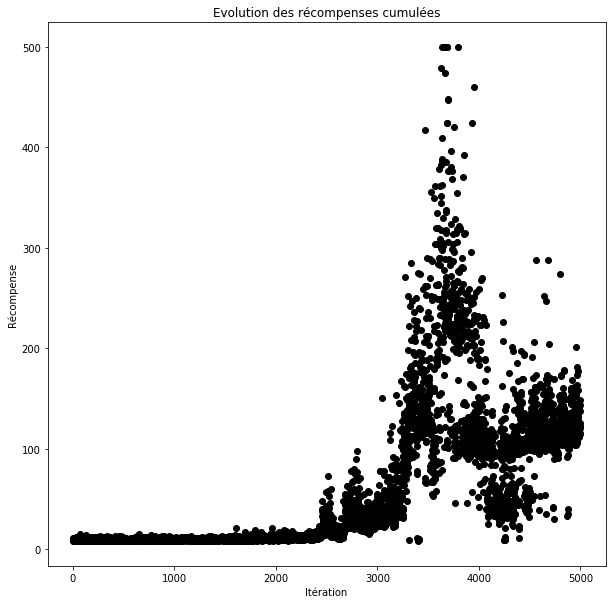

In [71]:
plot_reward(rewards, "Evolution des récompenses cumulées", file_name=f"dot_{episode_count}_{batch_size}", mean_size=1)

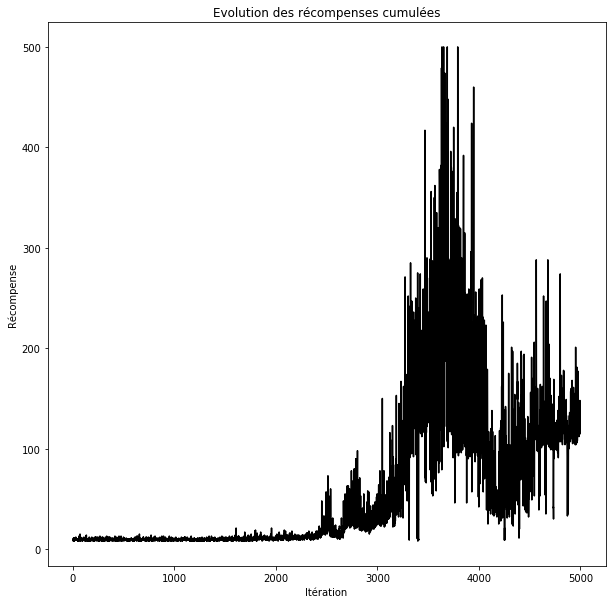

In [80]:
plot_reward(rewards, "Evolution des récompenses cumulées", file_name=f"bar_{episode_count}_{batch_size}", mean_size=1)